In [44]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

records = pd.read_csv('recorded_runs.csv')
records.loc[records['Model Description'] == 'NER Transformer With One LSTM', 'Model Description'] = 'NER Transformer With One Direction LSTM'

**Evaluation**

The primary metric we will use for evaluating model is the micro F5 score. Micro F5 is related to F1-score, the harmonic mean of precision (True Positives / Total Number of Positive Predictions) and recall (True Positives / Total Number of Actual Positives in the dataset). The 5 in the F5 score refers to beta = 5, which makes recall 5 times as important as precision. 

In [36]:
from IPython.display import Image

Image(url = 'images/1_pqzLmhG02QIvllTT_F-2KA.jpeg', width = 1000, height = 100)

**Presidio Analyzer**

Presidio Analyzer enhanced with the custom regex, id, address, and signal phrase pattern recognizers did quite well with a micro F5 score of 0.77. This high score is most likely due to its high recall, labelling 83% of actual positive labels correctly. However, the model predicted that many more tokens would be labels than actually were labels (there were a high number of false positives), so it has a much lower precision. In fact, the number of false positives is almost double that of the number of true positives. 

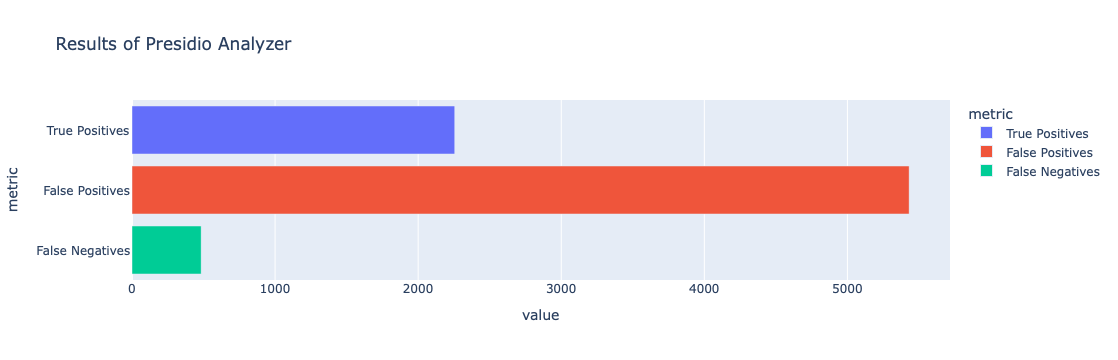

In [33]:
#Confusion Matrix Display
from sklearn.metrics import ConfusionMatrixDisplay

#Presidio Confusion Matrix

presidio = {'True Positives': 2256, 'False Positives': 5431,
            'True Negatives': 4984383, 'False Negatives': 483,
            'Precision': 0.2942480761706013,
            'Recall': 0.8297168076498713,
            'F1-Score': 0.4344309647602542,
            'Micro F5 Score': 0.7703501352735678}

presidio = pd.DataFrame.from_dict(presidio, orient='index').reset_index()
presidio.columns = ['metric','value']

sample_sizes = presidio.iloc[:4,:]

sample_sizes = sample_sizes.drop(index = 2, axis = 0)

fig = px.bar(sample_sizes, x = 'value', y = 'metric', title = 'Results of Presidio Analyzer', color = 'metric')

fig.show()

While this may seem like a lot of false positives, keep in mind that there were only 2739 positive labels out of almost 5 million labels! The pie chart below emphasizes this point!

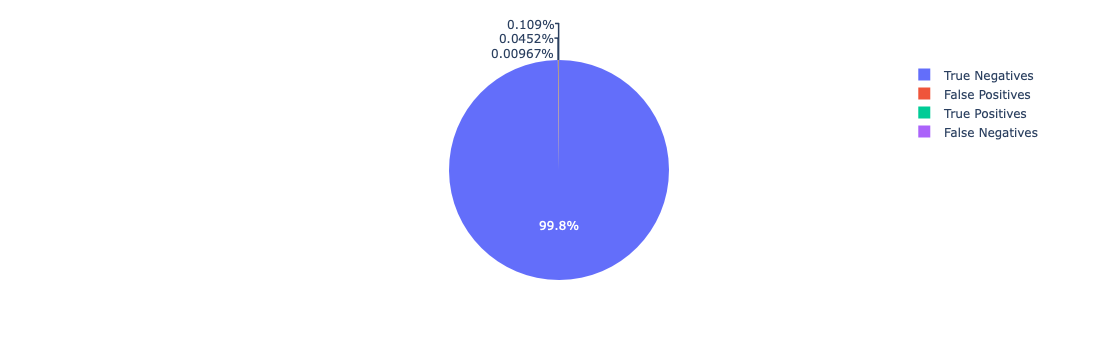

In [39]:
fig = px.pie(presidio.iloc[:4,:], values = 'value', names = 'metric')
fig.show()

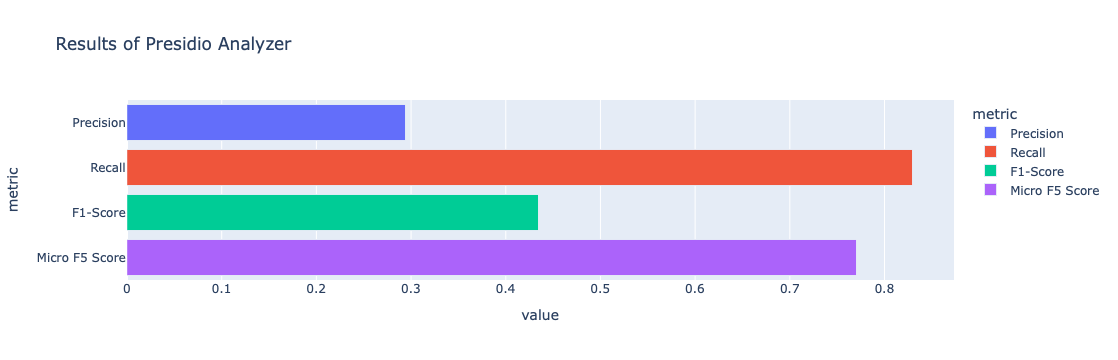

In [34]:
fig = px.bar(presidio.iloc[4:,:], x = 'value', y = 'metric', title = 'Results of Presidio Analyzer', color = 'metric')

fig.show()

**Transformer Networks**

After testing the Presidio Analyzer model out, we turned to deep neural networks with various architectures to determine what kind of model architecture would produce the best results. 

In [42]:
Image(url = 'https://cdn-images-1.medium.com/v2/resize:fit:1600/0*aWIO7eB6E4-cIkK9.gif',width = 500, height = 100)

The first question was: what is a good subset of data to test? How do we split the testing and training data? We tried testing the dataset on the full essay text as well as on all sentence tokens in the essay. The whole point of this exercise was to figure out how much context was optimal for the model to recognize PII, so we did not test individual tokens in the model.

Not surprisingly, the best results were found when we identified which sentences with PII labels and created a more balanced data set on the sentence level. Sentences were faster to process than full essays, and with more labels to learn from models performed much better, sometimes with comparable results almost at the range of Presidio Analyzer with pattern recognition enhancement!

When we trained the model on the full essay text, the standard model without an LSTM achieved a very low F5 score of 0.207 because out of the 1,005,699 there were only 523 actual labels. The model was about to guess about one hundred of the labels correctly, but with such low occurenced, the error was high. 

Now that we figured out how to balance the sample to produce not so bad results, we turned to running some neural network models. To get a high overview, we initially ran about 50 models to compare between transformers with traditional Dense() layers, normal LSTMs, and bidirectional LSTMs. For the same model architecture, we had some huge fluctuations due to gradient descent, but in general, we found that traditional neural networks produce a higher number of false positives than bidirectional and normal LSTMs. However, LSTMs tended to have similar or even better performance on finding true positives. Thus, we decided to delve more deeply into discovering whether LSTMs can have comparable performance to Presidio Analyzer with rule-based regex enhancement.

In [49]:
pd.DataFrame(records['Model Description'].value_counts())

,count
Model Description,
NER Transformer With Bidirectional LSTM,38
NER Transformer Without LSTM,9
NER Transformer With One Direction LSTM,4


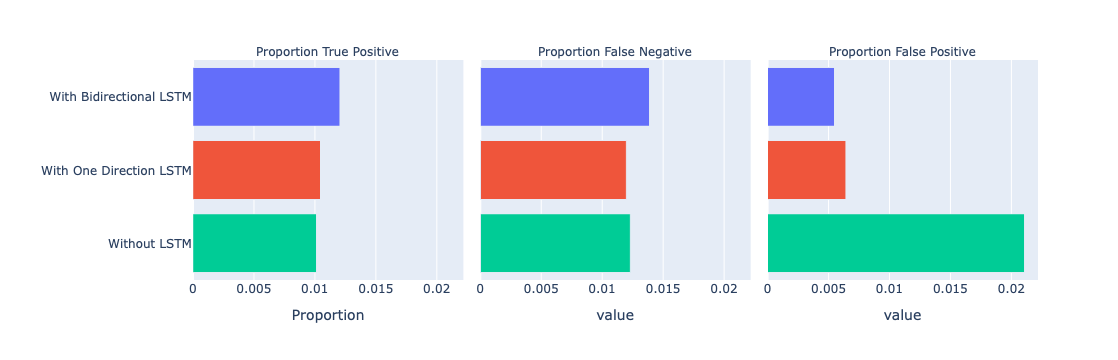

In [75]:
counts_df = records.copy()
counts_df['Proportion True Positive'] = counts_df['True Positive'] / counts_df['Sample Size']
counts_df['Proportion False Negative'] = counts_df['False Negative'] / counts_df['Sample Size']
counts_df['Proportion False Positive'] = counts_df['False Positive'] / counts_df['Sample Size']

prop = counts_df.filter(regex = 'Proportion|Description').groupby('Model Description').mean().reset_index()
prop = pd.melt(prop, id_vars = ['Model Description'], value_vars = ['Proportion True Positive',
                                                                    'Proportion False Negative',
                                                                    'Proportion False Positive'])

prop['Model Description'] = prop['Model Description'].str.replace('NER Transformer','')

fig = px.bar(prop,
             x = 'value',
             y = 'Model Description',
             facet_col = 'variable',
             color = 'Model Description')
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_yaxes(type = 'category')
fig.update_layout(showlegend = False,
                  xaxis_title = '',
                  yaxis_title = '')
fig.show()

In the first round, the models tested with and without the LSTM layers had overlaps in performance depending on the parameters used and batch size of the test datasets. Bidirectional LSTM was tested most extensively. We were able to find instances where the bidirectional LSTM outperformed models without an LSTM on the micro F5 score, but there were also instances where bidirectional LSTM performed worse. 

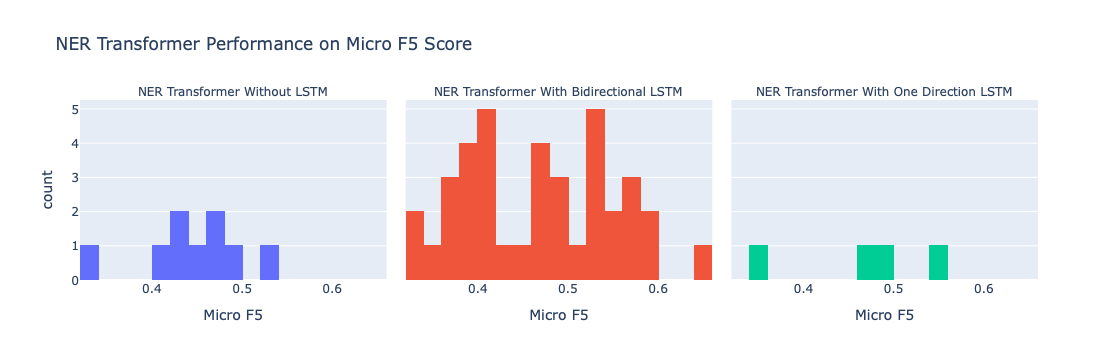

In [184]:
fig = px.histogram(records, x='Micro F5',
                     color = 'Model Description',
                     facet_col = 'Model Description',
                     title = 'NER Transformer Performance on Micro F5 Score',
                     nbins = 30)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_layout(showlegend = False)
fig.show()

However, each model does have its advantages. The Named Entity Recognizer (NER) Transformer block with a Bidirectional LSTM generates much higher precision than recall, while the NER transformer with a simple dense neural network performs tends to do better on recall than precision. The few instances where we tested the NER Transformer with just an LSTM yielded comparable performance to the Bidirectional LSTM layer in precision and recall for models of similar size.

Typically, medium small Bidirectional LSTM models (with dimensions of 32 and 64 in the transformer layer) with fewer transformer heads performed best, while medium large models with more heads and dimensions of 64 and 128 in the transformer layer performed best.

We chose to focus more on the Bidrectional LSTM in performing model evaluations because we are able to similar recall performance with much better performance on precision.

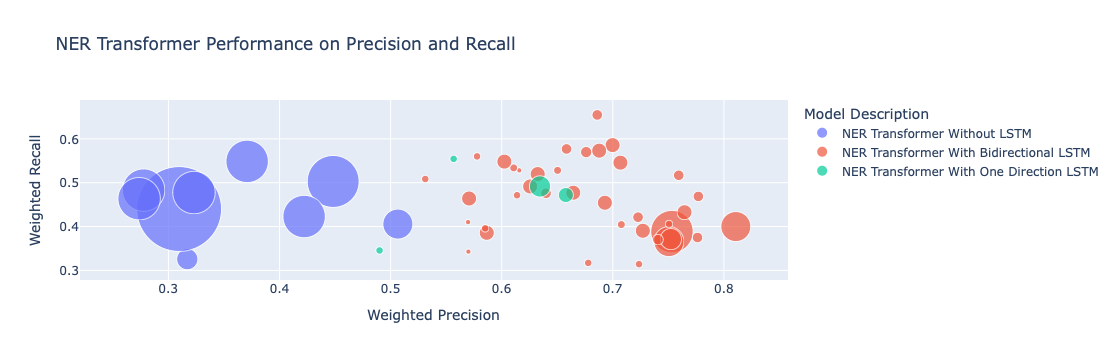

In [15]:
records['# heads x embed_dim x ff_dim'] = records['Num Transformer Heads'] * records['embed_dim'] * records['ff_dim']
fig = px.scatter(records, x='Weighted Precision',
                 y = 'Weighted Recall', 
                 size = '# heads x embed_dim x ff_dim',
                 color = 'Model Description',
                 hover_data = ['Micro F5',
                               'Num Transformer Heads',
                               'embed_dim',
                               'ff_dim',
                               'Batch Size'],
                 title = 'NER Transformer Performance on Precision and Recall',
                 size_max = 60)
fig.show()

The number of transformer heads seems to correlate with the Micro F5 score, at least in these initial 50 model runs. For Bidirectional LSTMs fewer heads were associated with higher scores. For the NER transformer without the LSTM, increasing the number of heads resulted in an increase in the average Micro F5 score.

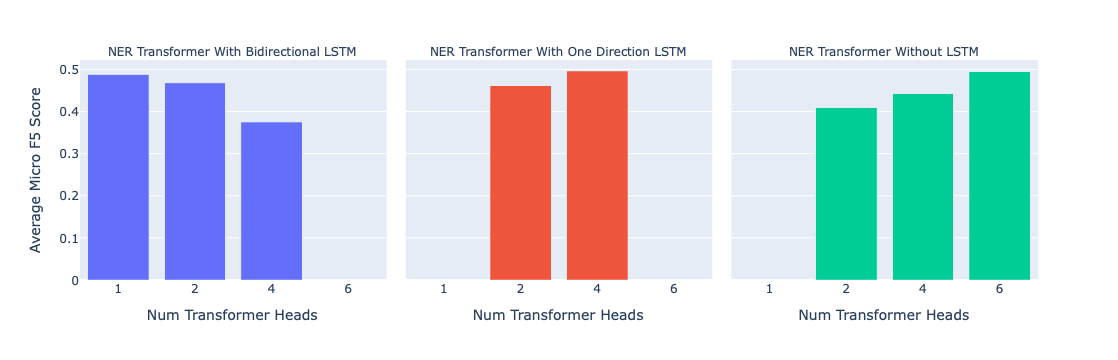

In [41]:
#Impact of Number of Transformer Heads
microf5_transformer = records[['Num Transformer Heads',
                               'Micro F5',
                               'Model Description']].groupby(['Num Transformer Heads','Model Description']).mean().reset_index()

fig = px.bar(microf5_transformer,
             x = 'Num Transformer Heads',
             y = 'Micro F5',
             facet_col = 'Model Description',
             color = 'Model Description')
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_xaxes(type = 'category')
fig.update_layout(showlegend = False,
                  yaxis_title = 'Average Micro F5 Score')
fig.show()


In [142]:
%run nlp-functions.ipynb

with open('Results.txt','r') as f:
    lstm_2head = f.readlines()
    f.close()
while (lstm_2head.count('\n')):
    lstm_2head.remove('\n')

lstm2 = RecordDataFrame()
runs = int(len(lstm_2head) / 7)

start_idx = 0
end_idx = 7
for i in range(runs):
    r = {'Dataset Type': 'validation'}
    for item in lstm_2head[start_idx:end_idx]:
        a = item.replace("\n","")
        if 'processed' in item:
            value = a.split(" ")
            r.update({'Sample Size' : int(value[1])})
        elif 'Model' in item:
            clean_txt = a.replace("{", "")
            clean_txt = clean_txt.replace("}", "")
            clean_txt = clean_txt.replace("'", "")
            clean_txt = clean_txt.split(",")
            for txt in clean_txt:
                txt = txt.split(": ")
                if 'Model' in txt[0]:
                    r.update({txt[0].strip(): txt[1]})
                else:
                    r.update({txt[0].strip(): int(txt[1])})
        elif 'Positive' in item:
            clean_txt = a.replace("{", "")
            clean_txt = clean_txt.replace("}", "")
            clean_txt = clean_txt.replace("'", "")
            clean_txt = clean_txt.split(",")
            for txt in clean_txt:
                txt = txt.split(": ")
                r.update({txt[0].strip(): int(txt[1])})
        else:
            txt = a.split(": ")
            r.update({txt[0] : float(txt[1])})
    lstm2.add_record(r)
    start_idx += 7
    end_idx += 7

lstm2.to_csv('lstm2.csv')

df = lstm2.copy()
file_names = [file for file in os.listdir() if 'lstm' in file][2:]
print('Items Removed:')
file_names.pop(2)
file_names.pop(3)
for file in file_names:
    df = pd.concat([df, pd.read_csv(file)], axis = 0)
df = df.drop('Unnamed: 0',axis=1).reset_index(drop = True)
df = df.convert_dtypes()

In the second round, we ran 131 bidirectional models and 108 original LSTM models to test out different parameters. We tried variations on the parameters below. Due to training time constraints, we decided to mostly use a batch size of 16, which we found to be faster, and more accurate for Bidirectional LSTMs. On each variable, we tried to account for variations in gradient descent by running each hyperparameter combination in three separte models. We found that gradient descent can produce extreme variations in scores, and it even resulted in 0 true positives 12 times because the model did not find a suitable path to decrease loss.

Overall, the Bidirectional LSTM has a better performance and lower standard deviation. Thus it seems to be slightly more reliable than the normal LSTM. In the histogram below, we also see that the bidirectional LSTM has more occurences of the highest Micro F5 scores, though both models inhabit a similar range.

In [227]:
df[['Model Description','Micro F5']].groupby('Model Description').describe().T

Model Description  NER Transformer With Bidirectional LSTM  \
Micro F5 count                                       131.0   
         mean                                     0.514649   
         std                                      0.139643   
         min                                           0.0   
         25%                                      0.452895   
         50%                                      0.521127   
         75%                                      0.592329   
         max                                      0.790391   

Model Description  NER Transformer With One LSTM  
Micro F5 count                             108.0  
         mean                           0.478247  
         std                            0.160132  
         min                                 0.0  
         25%                            0.439782  
         50%                            0.503795  
         75%                            0.565718  
         max                            0.768609

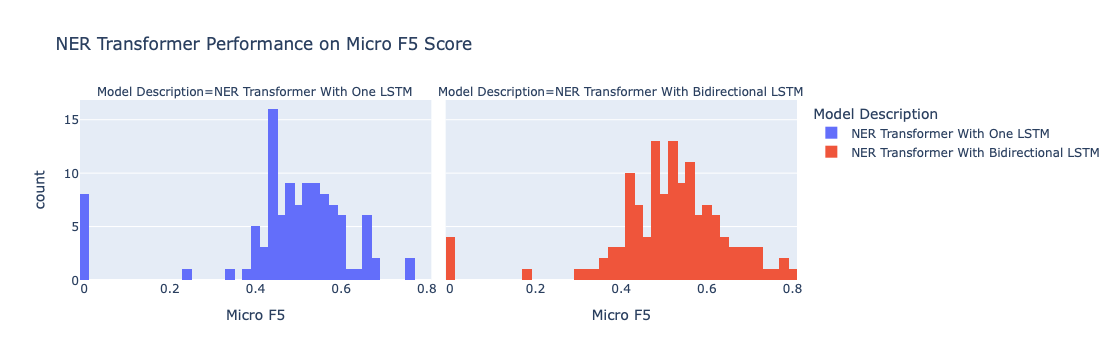

In [183]:
fig = px.histogram(df, x='Micro F5',
                     color = 'Model Description',
                     facet_col = 'Model Description',
                     title = 'NER Transformer Performance on Micro F5 Score',
                     nbins = 50)
fig.show()

Both models had similar precision and recall, but the bidirectional LSTM tends to skew more to the right, resulting in the highest precision scores of about 0.9.

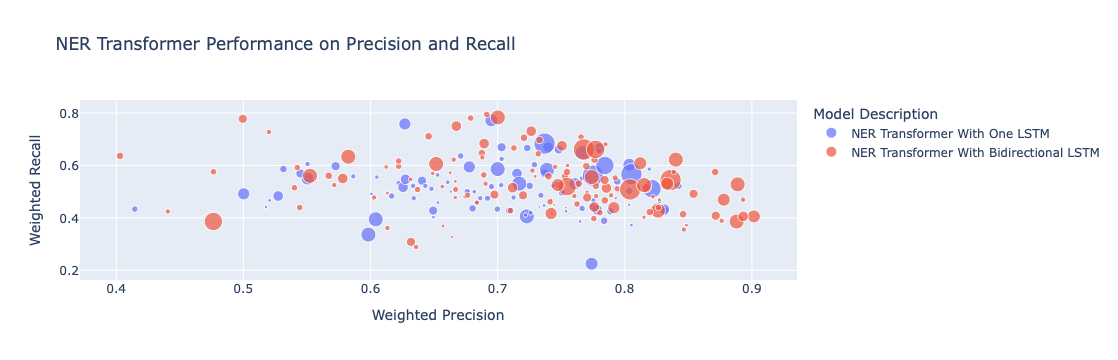

In [222]:
df['# heads x embed_dim x ff_dim'] = df['Num Transformer Heads'] * df['embed_dim'] * df['ff_dim']
fig = px.scatter(df.loc[(df['Weighted Recall'] > 0.2) & (df['Weighted Precision'] > 0.2),:], 
                 x='Weighted Precision',
                 y = 'Weighted Recall', 
                 size = '# heads x embed_dim x ff_dim',
                 color = 'Model Description',
                 hover_data = ['Micro F5',
                               'Num Transformer Heads',
                               'embed_dim',
                               'ff_dim',
                               'Batch Size'],
                 title = 'NER Transformer Performance on Precision and Recall',
                 size_max = 15)
fig.show()

Looking back at the role transformer heads play, Micro F5 performance for both models seems pretty even for 1, 2, and 4 transformer heads, but is noticeably smaller when we get to 8 transformer heads. This could be related to how larger models have higher standard deviation, as we will see later.

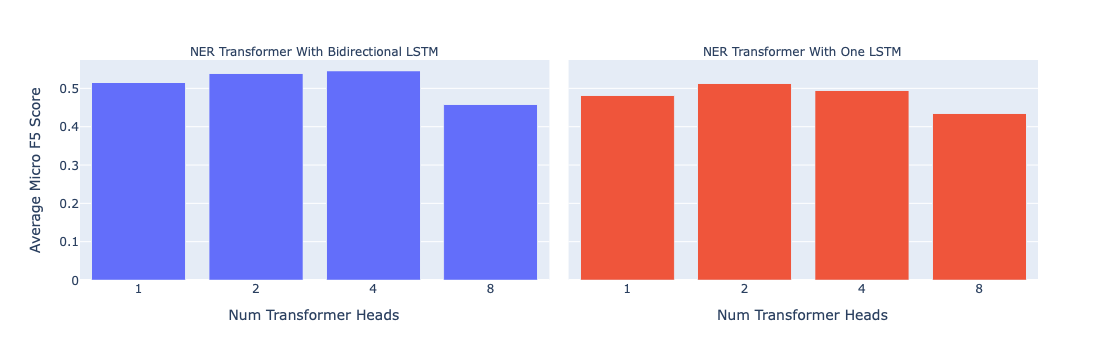

In [175]:
#Impact of Number of Transformer Heads
microf5_transformer = df[['Num Transformer Heads',
                               'Micro F5',
                               'Model Description']].groupby(['Num Transformer Heads','Model Description']).mean().reset_index()

fig = px.bar(microf5_transformer,
             x = 'Num Transformer Heads',
             y = 'Micro F5',
             facet_col = 'Model Description',
             color = 'Model Description',
             orientation = 'v')
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_xaxes(type = 'category')
fig.update_layout(showlegend = False,
                  yaxis_title = 'Average Micro F5 Score')
fig.show()


Presidio Analyzer with regex enhancement was able to achieve a Micro F5 score of 0.77. Some of our models did have a similar performance on more balanced validation datasets generated from sentence tokens. What are some characteristics of these high-performing models/

Looking at the number of transformer heads by LSTM type with a Micro F5 Score of over 0.7, the first thing we notice is that there aren't many models with normal LSTMs in this category. The bidirectional LSTM beats wins here.

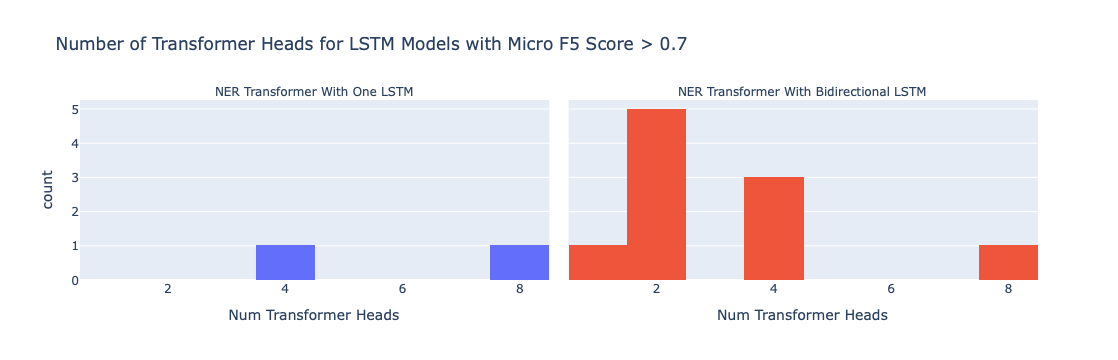

In [244]:
compare_presidio = df.loc[df['Micro F5'] > 0.7]

fig = px.histogram(compare_presidio, x='Num Transformer Heads',
                     color = 'Model Description',
                     facet_col = 'Model Description',
                     title = 'Number of Transformer Heads for LSTM Models with Micro F5 Score > 0.7',
                     nbins = 8
                     )
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
#fig.update_xaxes(type = 'category')
fig.update_layout(showlegend = False)
                  
fig.show()

In the plot below, we can see that larger model sizes particularly for normal LSTMs are correlated with large standard deviations in model performance. In fact, out of the top ten models with largest standard deviation, eight are normal LSTMs! All of these examples have one model that was not optimized and had 0 correct prodictions. This could be related to the vanishing gradient problem that bidirectional LSTMs are trying to avoid.

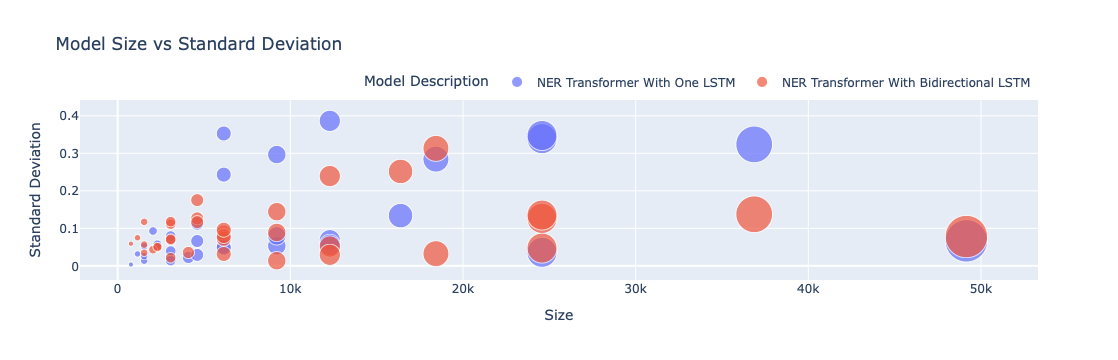

In [318]:
models.columns = [ 'count', 'mean','std','min','25%','50%','75%','max',
                  'Model Description',        'Num Transformer Heads',
                          'embed_dim',                       'ff_dim',
           'heads x embed_dim x ff_dim',                    'Model No.']
fig = px.scatter(models,
                 x= '# heads x embed_dim x ff_dim',
                 y = 'std', 
                 size = '# heads x embed_dim x ff_dim',
                 color = 'Model Description',
                 hover_data = ['Num Transformer Heads',
                               'embed_dim',
                               'ff_dim',
                               'mean'],
                 title = 'Model Size vs Standard Deviation',
                 size_max = 30)

fig.update_layout(legend=dict(
                    orientation="h",
                    yanchor="bottom",
                    y=1.02,
                    xanchor="right",
                    x=1)
                )

fig.update_layout(showlegend = False,
                  yaxis_title = 'Standard Deviation',
                  xaxis_title = 'Size')
fig.show()

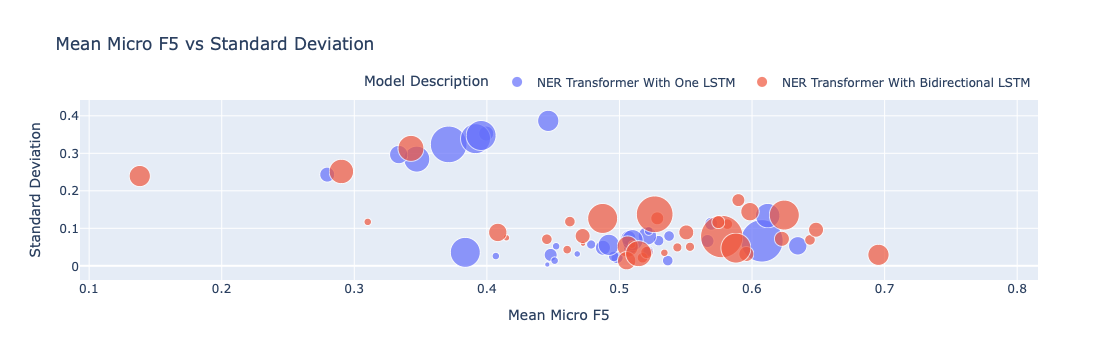

In [326]:
# models.columns = [ 'count', 'mean','std','min','25%','50%','75%','max',
#                   'Model Description',        'Num Transformer Heads',
#                           'embed_dim',                       'ff_dim',
#            'heads x embed_dim x ff_dim',                    'Model No.']
fig = px.scatter(models,
                 x= 'mean',
                 y = 'std', 
                 size = '# heads x embed_dim x ff_dim',
                 color = 'Model Description',
                 hover_data = ['Num Transformer Heads',
                               'embed_dim',
                               'ff_dim',
                               'mean'],
                 title = 'Mean Micro F5 vs Standard Deviation',
                 size_max = 30)

fig.update_layout(legend=dict(
                    orientation="h",
                    yanchor="bottom",
                    y=1.02,
                    xanchor="right",
                    x=1)
                )

fig.update_layout(#showlegend = False,
                  yaxis_title = 'Standard Deviation',
                  xaxis_title = 'Mean Micro F5')
fig.show()

In [251]:
unique_models = df[['Model Description','Num Transformer Heads','embed_dim','ff_dim']].drop_duplicates().reset_index(drop = True)
df["Model No."] = ''

for row in tqdm(range(len(unique_models))):
    df.loc[(df['Model Description'] == unique_models.loc[row, 'Model Description']) & 
            (df['Num Transformer Heads'] == unique_models.loc[row, 'Num Transformer Heads']) &
            (df['embed_dim'] == unique_models.loc[row, 'embed_dim']) &
            (df['ff_dim'] == unique_models.loc[row, 'ff_dim']), 'Model No.'] = row

  0%|          | 0/73 [00:00<?, ?it/s]

**Best Model Architecture**

Although the original LSTM can perform as well as the bidirectional LSTM given certain hyperparameters (as seen below), bidirectional LSTM does have more occurences of high performing models overall, and it proves more reliable for larger model sizes, especially with eight transformer heads. 

As for the best model dimensions, the top 10 models with the highest mean on Micro F5 score seem to indicate a medium-sized model as the best option. We do not see any models with 1 attention head and a small number of parameters. Instead, we see more models veering towards 32 and 48 embed_dim and 64 and 96 ff_dim. We also have a smattering transformer heads. There might not be one best architecture, but it is pretty clear that we a good balance. The smallest models seem to have mediocre performance, but the larger models are likely to have higher standard deviation. It's good to find that sweet spot, but with the variation on gradient descent, it can be tricky.


In [317]:
models = df.loc[df['Dataset Type'] == 'validation',['Micro F5','Model No.']].groupby('Model No.').describe()

unique_models = df[['Model Description','Num Transformer Heads','embed_dim','ff_dim',
                    '# heads x embed_dim x ff_dim',
                    'Model No.']].drop_duplicates().reset_index(drop = True)
models = pd.concat([models,unique_models], axis = 1)

models.sort_values(('Micro F5',  'mean'), ascending = False).head(10)

,"(Micro F5, count)","(Micro F5, mean)","(Micro F5, std)","(Micro F5, min)","(Micro F5, 25%)","(Micro F5, 50%)","(Micro F5, 75%)","(Micro F5, max)",Model Description,Num Transformer Heads,embed_dim,ff_dim,# heads x embed_dim x ff_dim,Model No.
15,1.0,0.768609,<NA>,0.768609,0.768609,0.768609,0.768609,0.768609,NER Transformer With One LSTM,4,48,96,18432,15
52,1.0,0.744749,<NA>,0.744749,0.744749,0.744749,0.744749,0.744749,NER Transformer With Bidirectional LSTM,4,32,96,12288,52
40,3.0,0.695366,0.029347,0.676228,0.678472,0.680715,0.704934,0.729153,NER Transformer With Bidirectional LSTM,2,64,96,12288,40
47,3.0,0.648275,0.096253,0.537271,0.618106,0.69894,0.703776,0.708613,NER Transformer With Bidirectional LSTM,4,24,64,6144,47
45,3.0,0.643707,0.069076,0.582153,0.606354,0.630556,0.674485,0.718414,NER Transformer With Bidirectional LSTM,2,32,48,3072,45
5,3.0,0.634507,0.053271,0.57318,0.61711,0.66104,0.665171,0.669301,NER Transformer With One LSTM,2,48,96,9216,5
33,3.0,0.624341,0.135316,0.532625,0.546636,0.560647,0.670199,0.779751,NER Transformer With Bidirectional LSTM,8,48,64,24576,33
42,3.0,0.622539,0.071973,0.579582,0.580993,0.582405,0.644018,0.705631,NER Transformer With Bidirectional LSTM,2,32,96,6144,42
71,3.0,0.611831,0.133781,0.486161,0.541514,0.596868,0.674666,0.752465,NER Transformer With One LSTM,8,32,64,16384,71
67,3.0,0.607466,0.066569,0.565339,0.569094,0.572848,0.628529,0.684211,NER Transformer With One LSTM,8,64,96,49152,67


In [321]:
models.sort_values('std', ascending = False).head(10)

,count,mean,std,min,25%,50%,75%,max,Model Description,Num Transformer Heads,embed_dim,ff_dim,# heads x embed_dim x ff_dim,Model No.
4,3.0,0.4463,0.386508,0.0,0.334226,0.668452,0.66945,0.670447,NER Transformer With One LSTM,2,64,96,12288,4
57,3.0,0.399511,0.352822,0.0,0.265076,0.530152,0.599266,0.66838,NER Transformer With One LSTM,1,64,96,6144,57
70,3.0,0.395644,0.347501,0.0,0.267767,0.535533,0.593466,0.651398,NER Transformer With One LSTM,8,48,64,24576,70
69,3.0,0.391446,0.339004,0.0,0.29295,0.5859,0.587168,0.588437,NER Transformer With One LSTM,8,32,96,24576,69
68,3.0,0.371185,0.323762,0.0,0.259099,0.518198,0.556777,0.595357,NER Transformer With One LSTM,8,48,96,36864,68
26,3.0,0.342751,0.313132,0.0,0.207205,0.41441,0.514126,0.613842,NER Transformer With Bidirectional LSTM,8,24,96,18432,26
65,3.0,0.33354,0.296635,0.0,0.216407,0.432815,0.500311,0.567807,NER Transformer With One LSTM,8,24,48,9216,65
63,4.0,0.347146,0.284509,0.0,0.173591,0.389878,0.563433,0.608827,NER Transformer With One LSTM,8,24,96,18432,63
34,3.0,0.29024,0.251612,0.0,0.212003,0.424005,0.435361,0.446716,NER Transformer With Bidirectional LSTM,8,32,64,16384,34
66,3.0,0.279589,0.243209,0.0,0.198257,0.396514,0.419384,0.442254,NER Transformer With One LSTM,8,24,32,6144,66


In [322]:
models.sort_values('max', ascending = False).head(10)

,count,mean,std,min,25%,50%,75%,max,Model Description,Num Transformer Heads,embed_dim,ff_dim,# heads x embed_dim x ff_dim,Model No.
48,3.0,0.589712,0.175101,0.468011,0.489373,0.510734,0.650563,0.790391,NER Transformer With Bidirectional LSTM,4,24,48,4608,48
33,3.0,0.624341,0.135316,0.532625,0.546636,0.560647,0.670199,0.779751,NER Transformer With Bidirectional LSTM,8,48,64,24576,33
36,10.0,0.574593,0.116409,0.404087,0.476539,0.594421,0.639803,0.776161,NER Transformer With Bidirectional LSTM,2,24,96,4608,36
15,1.0,0.768609,<NA>,0.768609,0.768609,0.768609,0.768609,0.768609,NER Transformer With One LSTM,4,48,96,18432,15
41,3.0,0.598445,0.144309,0.483983,0.517391,0.5508,0.655676,0.760552,NER Transformer With Bidirectional LSTM,2,48,96,9216,41
71,3.0,0.611831,0.133781,0.486161,0.541514,0.596868,0.674666,0.752465,NER Transformer With One LSTM,8,32,64,16384,71
52,1.0,0.744749,<NA>,0.744749,0.744749,0.744749,0.744749,0.744749,NER Transformer With Bidirectional LSTM,4,32,96,12288,52
40,3.0,0.695366,0.029347,0.676228,0.678472,0.680715,0.704934,0.729153,NER Transformer With Bidirectional LSTM,2,64,96,12288,40
45,3.0,0.643707,0.069076,0.582153,0.606354,0.630556,0.674485,0.718414,NER Transformer With Bidirectional LSTM,2,32,48,3072,45
21,4.0,0.528539,0.126578,0.427064,0.451693,0.488546,0.565392,0.710002,NER Transformer With Bidirectional LSTM,1,48,96,4608,21
